# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'dat-coreset'
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [10]:
get_dataloaders(X_train, y_train, X_val, y_val)

(<torch.utils.data.dataloader.DataLoader at 0x7c0a8ec79930>,
 <torch.utils.data.dataloader.DataLoader at 0x7c0a8ec78e50>)

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device
    set_seed(seed)

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    # print('start query')
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)

    model.eval()
    start_time = time.time()
    embeddings = []

    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)

        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6055, Accuracy: 0.8285, F1 Micro: 0.8825, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3994, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2438, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2239, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2275

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1908, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1556, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1219,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1506, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.098

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.367, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3524, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1875, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9599, F1 Micro: 0.969

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3415, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3284, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0467, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1838, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2861, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2982, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7461
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.298, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7628
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.278, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1853, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7266
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7941
Epoch 10/10, Train Loss: 0.0374, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2767, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7615
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.784
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.264, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1819, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9679, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2672, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7502
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7299
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7872
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0285, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2791, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1559, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0658, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.785
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8025
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.25, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7476
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7855
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7365
Epoch 10/10, Train Loss: 0.035, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.0783, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.749
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1315, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7371
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.72
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7872
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2516, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1123, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2397, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 4/10, Train Loss: 0.122, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 5/10, Train Loss: 0.0858, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.735
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.786
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7871
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Iteration 380: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2415, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1673, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.13, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.079, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2361, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1144, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7215
Epoch 5/10, Train Loss: 0.0752, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7297
Epoch 6/10, Train Loss: 0.0718, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7317
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7881
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7882
Epoch 10/10, Train Loss: 0.0209, Accurac

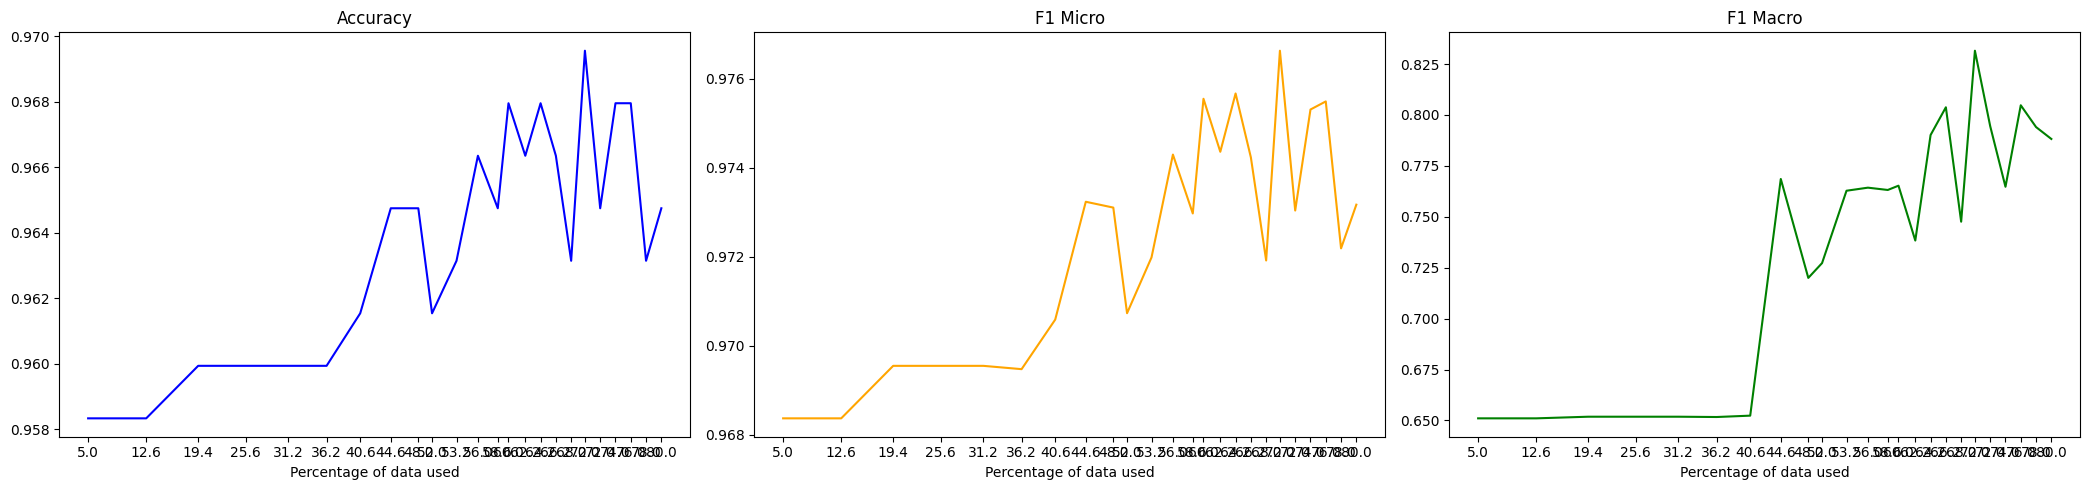

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6122, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.141, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1261, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1257, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4122, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1184, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0619, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1977, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.204, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3096, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2003, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0393, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3204, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1987, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2838, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7675
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0349, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2829, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1632, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0427, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2896, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1856, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7857
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7882
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9647, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7865
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.768
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.719
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7864
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0214, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7019
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8328
Epoch 8/10, Train Loss: 0.0278, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7936
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1669, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7967
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8161
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.258, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1415, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8225
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2353, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1724, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0758, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7468
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6957
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0246, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2599, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1194, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7031
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0302, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2589, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1429, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1061, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0808, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7368
Epoch 6/10, Train Loss: 0.0567, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8119
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0343, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8143
Epoch 1

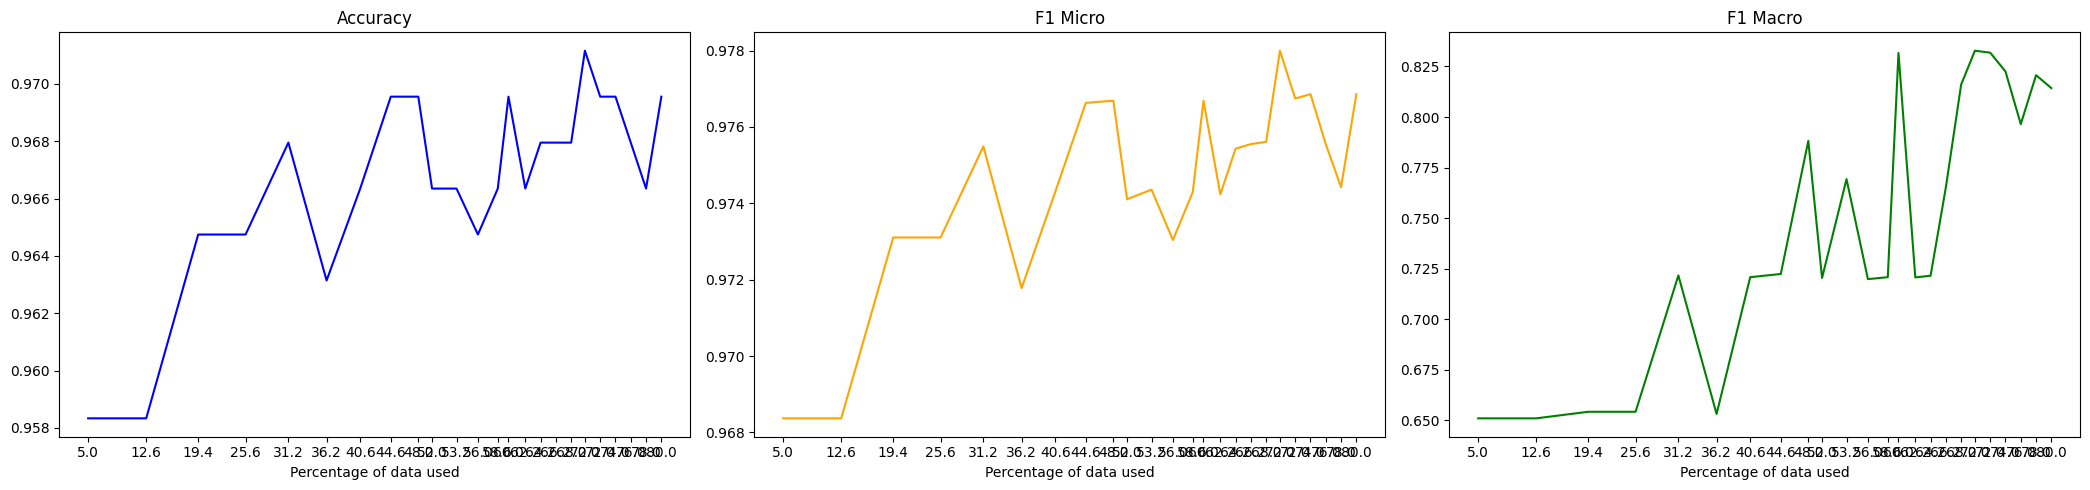

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3077, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1988, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2041, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1711, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1499, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.096

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9503, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1914, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1523, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1218, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9487, F1 Micro: 0.9601, F1 Macro: 0.6434
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.7136
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3338, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2105, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1822, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1573, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1899, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9519, F1 Micro: 0.9635, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.785
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9663, F1 Micro: 0.974

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3055, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6495
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2627, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1795, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.6502
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.7157
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7827
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8291
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2728, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.716
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.276, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1465, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.257, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7854
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7847
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7086
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7864
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7234
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8329
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7852
Epoch 10/10, Train Loss: 0.0315, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6568
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7223
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8049
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8041
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2516, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7103
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7891
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2518, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1766, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7001
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0249, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7187
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8328
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2466, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1541, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.104, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7892
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 6/10, Train Loss: 0.0769, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7855
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7854
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Iteration 370: Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.244, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.0932, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Epoch 6/10, Train Loss: 0.0661, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7949
Epoch 10/10, Train Loss: 0.0226, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2301, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.16, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1386, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0969, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7393
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.8017
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7015
Epoch 9/10, Train Loss: 0.0219, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0265, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2415, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1413, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1175, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.0774, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7021
Epoch 6/10, Train Loss: 0.071, Accuracy: 0.9551, F1 Micro: 0.9654, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.8172
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7114
Epoch 10/10, Train Loss: 0.0227, Accuracy:

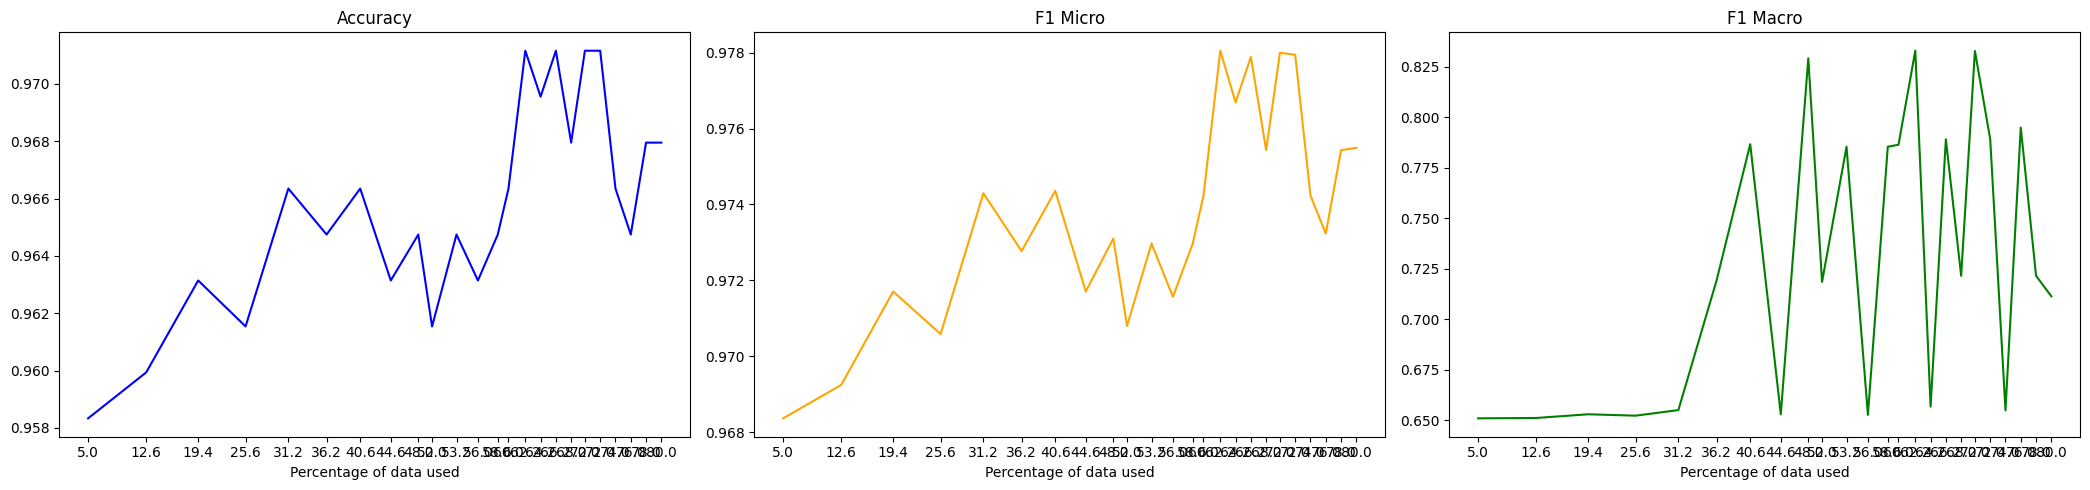

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3222, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2236, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2109, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1943, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1271, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1643, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.44, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1594, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.191, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1325, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1915, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.135, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2068, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9647, F1 Micro: 0.9728

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1866, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6505
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3046, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6532
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2963, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0506, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7657
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7071
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9583, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2443, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.03

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.259, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0281, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1892, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7635
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.247, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7932
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2461, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8303
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8295
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2353, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.8079
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2406, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1332, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.105, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7525
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8297
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7944
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0247, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2411, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8197
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0228, Accuracy: 0.9679, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2296, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.151, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1455, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.727
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.8017
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.804
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7929
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7931
Epoch 10/10, Train Loss: 0.0194, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2306, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8633
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2239, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1629, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7834
Epoch 7/10, Train Loss: 0.0535, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.8019
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0213, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2253, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1573, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0837, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0629, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0389, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7361
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8317
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.9615, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1822, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7365
Epoch 6/10, Train Loss: 0.0773, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7934
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7512
Epoch 10/

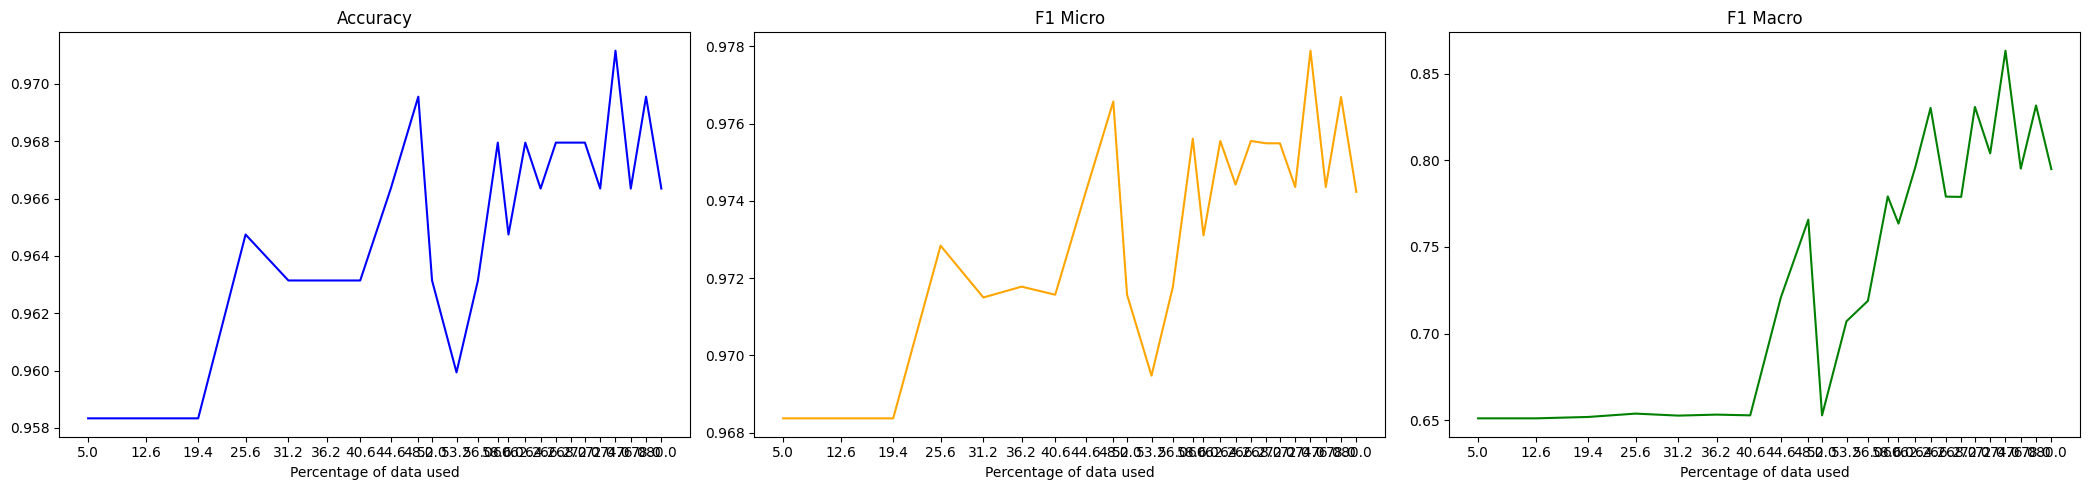

In [21]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1323, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1665, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1205,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0978, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 10/10, Train Loss: 0.0628, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2021, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1282, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 10/10, Train Loss: 0.0843, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.6556
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2863, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9663, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2788, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1589, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2748, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 10/10, Train Loss: 0.0325, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7491
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2727, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2673, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1764, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7141
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7938
Iteration 300: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2489, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0742, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.817
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8308
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1492, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7487
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7364
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2312, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7209
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0252, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8328
Epoch 10/10, Train Loss: 0.0301, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7965
Epoch 10/10, Train Loss: 0.0301, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2264, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1576, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0906, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.8329
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7647
Epoch 10/10, Train Loss: 0.0257, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2277, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.0865, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2376, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0993, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8328
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7451
Epoch 10/10, Train Loss: 0.0223, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2429, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1209, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0948, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Epoch 6/10, Train Loss: 0.0695, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7548
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0176, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2312, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1476, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1455, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0765, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7207
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 10/10, Train Loss: 0.018, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macr

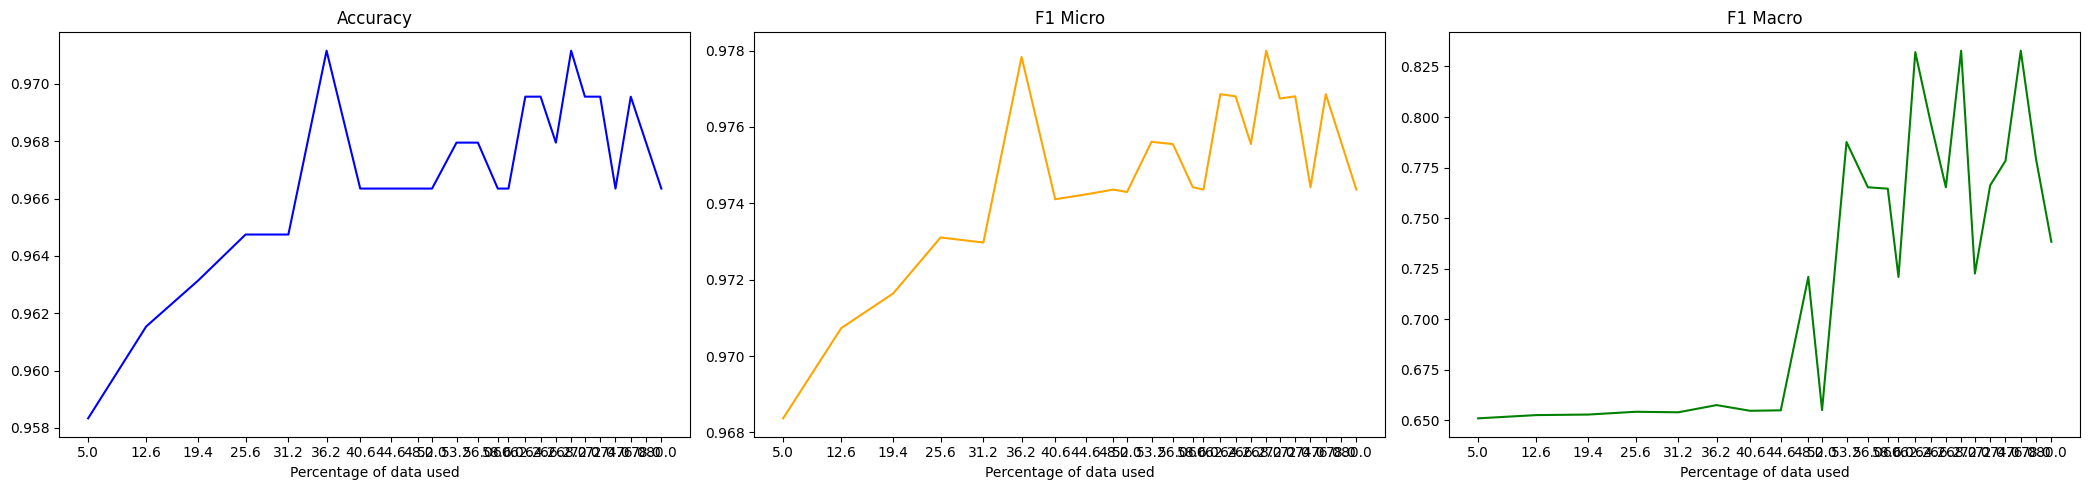

In [ ]:
active_learning(seeds[4], 4)